In [2]:
using QuadGK, PyPlot, DelimitedFiles

In [3]:
function xi(eta,u)
    q = clamp((1.0+eta)/(1.0-eta),-1e80,1e80)
    return (log(q)+u*1im)/(eta+tan(u/2)*1im)    
end

xi (generic function with 1 method)

In [4]:
function phi_pt1(r,t)
    eta = r/t
    q = clamp((1.0+eta)/(1.0-eta),-1e80,1e80)
    return exp(-t)/(4*pi*r*t^2)*t*log(q)
end

phi_pt1 (generic function with 1 method)

In [5]:
function integrand_pt(u,eta,t)
    return sec(u/2)^2*real((eta+1im*tan(u/2))*xi(eta,u)^3*exp(t/2*(1-eta^2)*xi(eta,u)))
end

integrand_pt (generic function with 1 method)

In [6]:
function phi_pt(r,t)
    r = clamp(r,1e-10,1e80)
    eta = r/t
    g = 0.0
    if eta<1.0
        g,error = quadgk(x->integrand_pt(x,eta,t),0,pi,atol = 1e-2)
    end
    f = 1/(2*pi)*exp(-t) /(4*pi*r*t^2)*(t/2)^2*(1-eta^2)*g
    f = f + phi_pt1(r,t)
    return f
end

phi_pt (generic function with 1 method)

In [7]:
function phi_l(t,r)
    eta = r/t
    if eta<1.0
        f,error = quadgk(w->phi_pt(t*sqrt(eta^2+w^2),t),0,sqrt(1-eta^2),atol = 1e-5)
        phi_l0 = exp(-t)/(2*pi*t^2) / sqrt(1-eta^2)
        return phi_l0 + (2*t)*f
    else
        return 0.0
    end
end

phi_l (generic function with 1 method)

In [8]:
function integrand(tau,r,sigmas,sigmaa)
   return  sigmas*exp(-(sigmaa+sigmas)*tau)*phi_l(tau,r-tau)
end

integrand (generic function with 1 method)

In [9]:
function getflux(t,x,y,omegax,omegay,sigmas,sigmaa)
    radii = sqrt.((x .- omegax*t).^2 .+ (y .- omegay*t).^2)
    return phi_l.(1.0 .- t,radii) 
end

getflux (generic function with 1 method)

In [10]:
function correctintegrand(t,x,y,omegax,omegay,sigmas,sigmaa)
    return exp.(-(sigmas+sigmaa).*t) .*getflux.(t,x,y,omegax,omegay,sigmas,sigmaa)
end

correctintegrand (generic function with 1 method)

In [58]:
function assemble(x,y,quadpoints)
    sigmaa = 0.0
    sigmas = 1.0
    flux = zeros(size(quadpoints)[1])
    for i=1:size(quadpoints)[1]
        omegax = quadpoints[i,1]
        omegay = quadpoints[i,2]
        #fl =getflux(t,x,y,omegax,omegay,sigmas,sigmaa);
        #flux[i] = (sum(fl .* exp.(-(sigmas+sigmaa).*t))/length(t))
        function myfun(tau)
            return correctintegrand(tau,x,y,omegax,omegay,sigmas,sigmaa)
        end
        dummy = (myfun(0.0))
        # instead of integrating to 1, see where we can cut the integral, maxbe this helps quadgk to not suck so hard

        flux[i],_ = quadgk(myfun,0,1,maxevals=200)
        #println(flux[i])
        #println(i)
    end
    return flux
end

assemble (generic function with 1 method)

In [59]:
quadpoints = readdlm("../points.txt");
quadweights = readdlm("../weights.txt")
x = 0.5
y = 0.5
t = 0.3
print(correctintegrand(t,x,y,0.3,0.3,1.0,1.0))
@time z = assemble(x,y,quadpoints);

0.30709761068461766  1.775545 seconds (4.93 M allocations: 121.056 MiB, 1.06% gc time)


In [60]:
nx = 100
ny = 100
nq = 36
X = range(0,stop=1.5,length=nx)
Y = range(0,stop=1.5,length=ny)
T =range(0,stop=1,length=10)

phi = zeros(nx,ny)
psi = zeros(nq,nx,ny)
for i=1:nx
    print(i)
    print(", ")
    for j=1:ny
        p = assemble(X[i],Y[j],quadpoints)
        phi[i,j] = sum(p .* quadweights)
        psi[:,i,j] = p 
    end
end

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 

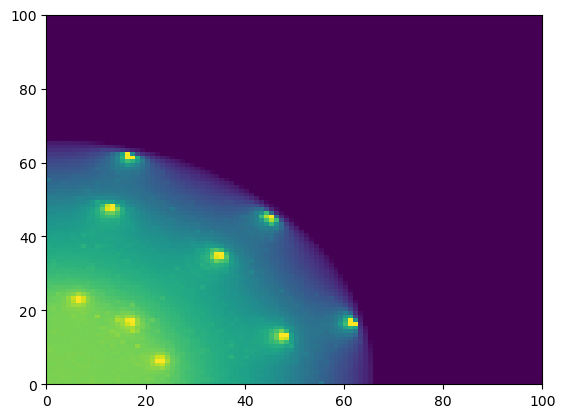

PyObject <matplotlib.collections.QuadMesh object at 0x7fe7cc5e6f10>

In [78]:
#oldphi = deepcopy(phi)
PyPlot.pcolormesh(phi/4/pi,vmin = 0,vmax = 0.4)
#savephi = deepcopy(phi)

In [65]:
sort(phi/4/pi)

UndefKeywordError: UndefKeywordError: keyword argument dims not assigned

In [69]:
phi

100×100 Array{Float64,2}:
 4.07684  4.01721  4.03294  4.00527  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.01721  4.01856  4.02795  4.04071     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.03294  4.02795  4.01694  4.02825     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.00527  4.04071  4.02825  4.02901     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.00692  4.02469  4.02576  4.0148      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.00199  4.00428  4.00846  4.00912  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.01295  4.0244   4.0368   4.01402     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.00799  3.99856  4.00654  4.01479     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.00764  4.00656  3.99557  3.9838      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.05957  4.0257   3.99711  4.02063     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.01035  3.99844  4.0017   3.98989  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.00905  3.98399  3.98348  4.00175     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.97764  3.99865  4.00204  3.98225     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮          